In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import copy

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

import pickle

In [2]:
names = []
band = []

directoty = "data/Train"
dirlist = os.listdir(directoty)
dirlist.sort()
for colorband in dirlist:
    l=[]
    imlist = os.listdir(directoty+ '/' +colorband)
    imlist.sort()
    for image in imlist:
        im = Image.open(directoty+ '/' +colorband + '/' + image)
        l.append(im)
    band.append(l)
    names.append(colorband)
TRAIN_X = [band[0],band[1],band[2],band[3]]
RAW_Y = band[5]
COR_Y = band[4]

In [3]:
names

['B2', 'B3', 'B4', 'B5', 'Cor', 'Raw']

In [4]:
names = []
band = []

directoty = "data/Test"
dirlist = os.listdir(directoty)
dirlist.sort()
for colorband in dirlist:
    l=[]
    imlist = os.listdir(directoty+ '/' +colorband)
    imlist.sort()
    for image in imlist:
        im = Image.open(directoty+ '/' +colorband + '/' + image)
        l.append(im)
    band.append(l)
    names.append(colorband)
TEST_X = [band[0],band[1],band[2],band[3]]
HAND_MAKE_Y = band[4]


In [5]:
%%time
X_train_ = []
Y_raw_ = []
Y_cor_ = []
#scaler = StandardScaler()

for r,g,b,n,m_r,m_c in zip(TRAIN_X[0],TRAIN_X[1],TRAIN_X[2],TRAIN_X[3],RAW_Y,COR_Y):
    width, height = r.size
    arr_r = np.array(r.getdata()).reshape((width,height))
    arr_g = np.array(g.getdata()).reshape((width,height))
    arr_b = np.array(b.getdata()).reshape((width,height))
    arr_n = np.array(n.getdata()).reshape((width,height))
    arr_m_r = np.array(m_r.getdata()).reshape((width,height))
    arr_m_c = np.array(m_c.getdata()).reshape((width,height))
    
    X_train_.append(np.stack([arr_r,arr_g,arr_b,arr_n]))
    Y_raw_.append(arr_m_r)
    Y_cor_.append(arr_m_c)
    
X_train_ = np.array(X_train_)
Y_cor_ = np.array(Y_cor_)
Y_raw_ = np.array(Y_raw_)

CPU times: user 9.45 s, sys: 264 ms, total: 9.72 s
Wall time: 9.84 s


In [6]:
print(X_train_.shape)
print(Y_cor_.shape)
print(Y_raw_.shape)

(300, 4, 192, 192)
(300, 192, 192)
(300, 192, 192)


In [6]:
X_test_ = []
Y_hand_make_ = []
for r,g,b,n,m in zip(TEST_X[0],TEST_X[1],TEST_X[2],TEST_X[3],HAND_MAKE_Y):
    width, height = r.size
    arr_r = np.array(r.getdata()).reshape((width,height))
    arr_g = np.array(g.getdata()).reshape((width,height))
    arr_b = np.array(b.getdata()).reshape((width,height))
    arr_n = np.array(n.getdata()).reshape((width,height))
    arr_m = np.array(m.getdata()).reshape((width,height))
    
    X_test_.append(np.stack([arr_r,arr_g,arr_b,arr_n]))
    Y_hand_make_.append(arr_m)

X_test_ = np.array(X_test_)
Y_hand_make_ = np.array(Y_hand_make_)

In [7]:
print(X_test_.shape)
print(Y_hand_make_.shape)

(61, 4, 192, 192)
(61, 192, 192)


In [8]:
Y_cor_[Y_cor_<150] = 0
Y_cor_[Y_cor_>=150] = 1
Y_raw_[Y_raw_<150] = 0
Y_raw_[Y_raw_>=150] = 1
Y_hand_make_[Y_hand_make_<150] = 0
Y_hand_make_[Y_hand_make_>=150] = 1

In [9]:
X= np.hstack([X_train_[:,0,:,:].reshape(-1,1),
          X_train_[:,1,:,:].reshape(-1,1),
          X_train_[:,2,:,:].reshape(-1,1),
          X_train_[:,3,:,:].reshape(-1,1)])
y = Y_raw_.reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)

X_test = np.hstack([X_test_[:,0,:,:].reshape(-1,1),
          X_test_[:,1,:,:].reshape(-1,1),
          X_test_[:,2,:,:].reshape(-1,1),
          X_test_[:,3,:,:].reshape(-1,1)])
y_test = Y_hand_make_.reshape(-1)
X_test.shape

(2248704, 4)

In [10]:
X_train.shape

(1105920, 4)

In [11]:
def jaccard_loss(pred,true,epsilon=0.0001):
    pred = pred.flatten()
    true = true.flatten()
    assert true.size() == pred.size()
    a = torch.sum(true*pred)
    b = torch.sum(true) + torch.sum(pred) - a 
    return -(a+epsilon)/(b+epsilon)

def model_evaluate(model,title):
    y_pred_train = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    print("Accuracy train: %.2f%%" % (accuracy * 100.0))
    y_pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    print("Accuracy test: %.2f%%" % (accuracy * 100.0))
    recall = recall_score(y_test,y_pred_test)
    print("Recall on test: %.2f%%" % (recall * 100.0))
    precision = precision_score(y_test,y_pred_test)
    print("Precision on test: %.2f%%" % (precision * 100.0))
    jaccard = jaccard_score(y_test,y_pred_test)
    print("Jaccard on test: %.2f%%" % (jaccard * 100.0))
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, y_pred_test))
    model_P_R = plot_precision_recall_curve(model, X_test, y_test)
    model_P_R.ax_.set_title(title +" Precision-Recall curve: ")
    plt.grid(True)

In [12]:
%%time
model_xgb = XGBClassifier(njobs = -1)
model_xgb.fit(X_train, y_train)


CPU times: user 4min 16s, sys: 104 ms, total: 4min 16s
Wall time: 1min 6s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, njobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Accuracy train: 95.34%
Accuracy test: 95.84%
Recall on test: 97.07%
Precision on test: 94.40%
Jaccard on test: 91.78%
Confusion matrix: 
[[1109961   62007]
 [  31575 1045161]]
CPU times: user 32.4 s, sys: 32 ms, total: 32.4 s
Wall time: 12.6 s


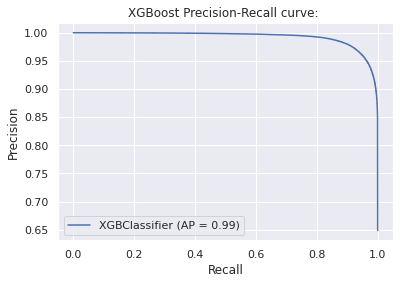

In [13]:
%%time
model_evaluate(model_xgb,"XGBoost")


Accuracy train: 94.29%
Accuracy test: 95.27%
Recall on test: 97.74%
Precision on test: 92.78%
Jaccard on test: 90.82%
Confusion matrix: 
[[1090030   81938]
 [  24382 1052354]]
CPU times: user 4min 42s, sys: 284 ms, total: 4min 42s
Wall time: 4min 42s


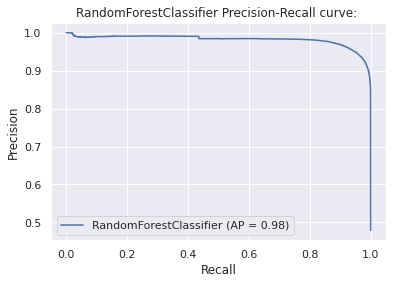

In [15]:
%%time
model_RF = RandomForestClassifier(max_depth=10)
model_RF.fit(X_train, y_train)
model_evaluate(model_RF,"RandomForestClassifier")

In [16]:
model_naive = GaussianNB()
model_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Accuracy train: 80.59%
Accuracy test: 83.98%
Recall on test: 69.45%
Precision on test: 95.97%
Jaccard on test: 67.49%
Confusion matrix: 
[[1140580   31388]
 [ 328893  747843]]
CPU times: user 6.61 s, sys: 64 ms, total: 6.67 s
Wall time: 6.66 s


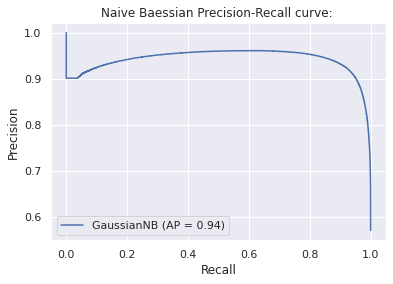

In [17]:
%%time
model_evaluate(model_naive,"Naive Baessian")


In [20]:
X= np.hstack([X_train_[:,0,:,:].reshape(-1,1),
          X_train_[:,1,:,:].reshape(-1,1),
          X_train_[:,2,:,:].reshape(-1,1),
          X_train_[:,3,:,:].reshape(-1,1)])
y = Y_cor_.reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)
X_test = np.hstack([X_test_[:,0,:,:].reshape(-1,1),
          X_test_[:,1,:,:].reshape(-1,1),
          X_test_[:,2,:,:].reshape(-1,1),
          X_test_[:,3,:,:].reshape(-1,1)])
y_test = Y_hand_make_.reshape(-1)
X_test.shape

(2248704, 4)

In [21]:
%%time
model_xgb_cor = XGBClassifier(njobs = -1)
model_xgb_cor.fit(X_train, y_train)


CPU times: user 1min 19s, sys: 28 ms, total: 1min 19s
Wall time: 20.1 s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, njobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Accuracy train: 94.50%
Accuracy test: 95.80%
Recall on test: 96.93%
Precision on test: 94.44%
Jaccard on test: 91.70%
Confusion matrix: 
[[1110543   61425]
 [  33032 1043704]]
CPU times: user 29 s, sys: 84 ms, total: 29.1 s
Wall time: 11.5 s


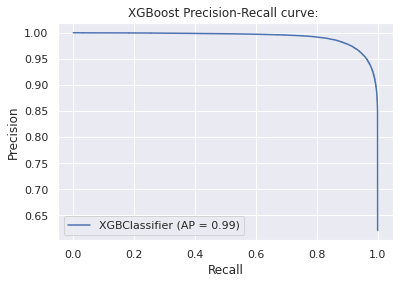

In [22]:
%%time
model_evaluate(model_xgb_cor,"XGBoost")

#### Save the best model

In [23]:
pickle.dump(model_xgb, open("cloudless/models/xgboost_raw.dat", "wb")) #save model traind on raw data
pickle.dump(model_xgb_cor, open("cloudless/models/xgboost_cor.dat", "wb")) #save model traind on corrected data
#pickle.dump(model_RF, open("cloudless/models/random_forest.dat", "wb"))
#pickle.dump(model_naive, open("cloudless/models/GaussianNB.dat", "wb"))

In [24]:
#remove all pictures containing only clouds or without clouds at all
color_ims_192 = []
masks_192 = []
for i,j in zip(X_test_,Y_hand_make_):
    if len(np.unique(j)) == 2:
        color_ims_192.append(i)
        masks_192.append(j)
color_ims_192 = np.array(color_ims_192)
masks_192 = np.array(masks_192)

#### Array of input images has to be a 4-dimensional array of shape [n_images, n_pixels_y, n_pixels_x, n_bands]

In [25]:
N = 59
first = 0
imgs = np.zeros((N,192,192,4))
imgs_mask = np.zeros((N,192,192))
j=0
for i in range(first,first+N):
    r = color_ims_192[i,0,...]
    g = color_ims_192[i,1,...]
    b = color_ims_192[i,2,...]
    n = color_ims_192[i,3,...]
    imgs[j]=np.dstack((r,g,b,n))
    imgs_mask[j] = masks_192[i]
    j+=1

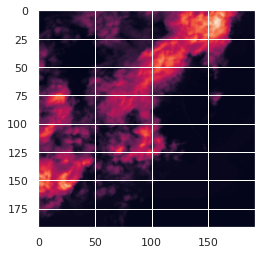

In [26]:
plt.imshow(imgs[0,...,0])

### Initialize the cloud detector 

We can specify the following arguments in the initialization of a `CloudDetector`:
 * `threshold` - cloud probability threshold value. All pixels with cloud probability above threshold value are masked as cloudy pixels. Default is `0.4`.
 * `average_over` - Size of the disk in pixels for performing convolution (averaging probability over pixels). For this resolution `4` is appropriate. 
 * `dilation_size` - Size of the disk in pixels for performing dilation.  For this resolution `2` is appropriate. 

Xgboost model trained on raw cloud masks

In [27]:
from cloudless import CloudDetector
cloud_detector = CloudDetector(threshold=0.7, average_over=4, dilation_size=2,model_filename = "xgboost_raw.dat")

/home/ilya/Machine learning/Project/FP/cloudless/models/xgboost_raw.dat


#### Run the classification

There are two possibilities:
 * `get_cloud_probability_maps` will return cloud probability map
 * `get_cloud_masks` will return binary cloud masks

In [28]:
cloud_probs = cloud_detector.get_cloud_probability_maps(imgs)

In [29]:
cloud_masks = cloud_detector.get_cloud_masks(imgs)

In [30]:
def plot_probability_map(spectral_images, prob_map, figsize=(15, 30)):
    """
    Utility function for plotting a RGB image and its cloud probability map next to each other. 
    """
    plt.figure(figsize=figsize)
    plot = plt.subplot(1, 2, 1)
    r = spectral_images[...,0]
    g = spectral_images[...,1]
    b = spectral_images[...,2]
    rgb = np.dstack((r,g,b))
    plt.imshow(rgb/rgb.max())
    plot = plt.subplot(1, 2, 2)
    plot.imshow(prob_map, cmap='coolwarm')

In [31]:
def plot_image_recreations(first_img_id,last_img_id):
    n_cols = 3
    n_rows = last_img_id-first_img_id
    fig = plt.figure(figsize=(15, 6*n_rows))
    for i in range(n_rows):
        ax = fig.add_subplot(n_rows, n_cols, n_cols*i+1)
        r = imgs[first_img_id+i,...,0]
        g = imgs[first_img_id+i,...,1]
        b = imgs[first_img_id+i,...,2]
        rgb = np.dstack((r,g,b))
        plt.imshow(rgb/rgb.max())
        ax1 = fig.add_subplot(n_rows, n_cols, n_cols*i+2)
        plt.imshow(imgs_mask[first_img_id+i], cmap='gray')
        ax2 = fig.add_subplot(n_rows, n_cols, n_cols*i+3)
        plt.imshow(cloud_masks[first_img_id+i], cmap='gray')
        plt.tight_layout()
        ax.set_title("True rgb image")
        ax1.set_title("Real image mask")
        ax2.set_title("Recreations by Cloud pixel detector")

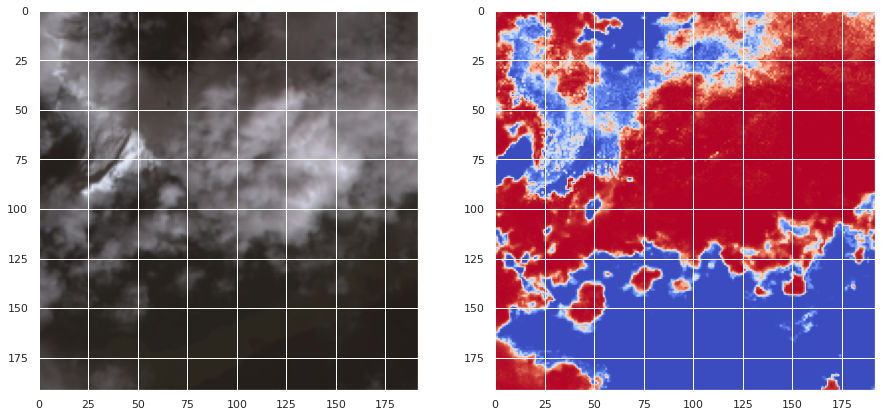

In [32]:
ind = 39
plot_probability_map(imgs[ind],cloud_probs[ind])

In [33]:
jac_score = []
prec_score = []
recall = []
acc_score = []
for i in range(len(cloud_masks)):
    pred = cloud_masks[i].flatten()
    true = imgs_mask[i].flatten()
    jac_score.append(np.round(jaccard_score(true,pred),2))
    prec_score.append(np.round(precision_score(true,pred),2))
    recall.append(np.round(recall_score(true,pred),2))
    acc_score.append(np.round(accuracy_score(true,pred),2))
jac_score.append(np.round(np.mean(jac_score),2))
prec_score.append(np.round(np.mean(prec_score),2))
recall.append(np.round(np.mean(recall),2))
acc_score.append(np.round(np.mean(acc_score),2))

jac_score.append(np.round(np.std(jac_score),2))
prec_score.append(np.round(np.std(prec_score),2))
recall.append(np.round(np.std(recall),2))
acc_score.append(np.round(np.std(acc_score),2))
dic = {'image №':list(range(len(cloud_masks)))+['mean']+['std'],'Jaccard':jac_score,'Precision':prec_score,'Recall':recall,'Overall Accuracy':acc_score}
df=pd.DataFrame(dic)
df.set_index('image №')
df.iloc[59:]

,image №,Jaccard,Precision,Recall,Overall Accuracy
59,mean,0.86,0.92,0.94,0.95
60,std,0.11,0.10,0.06,0.03


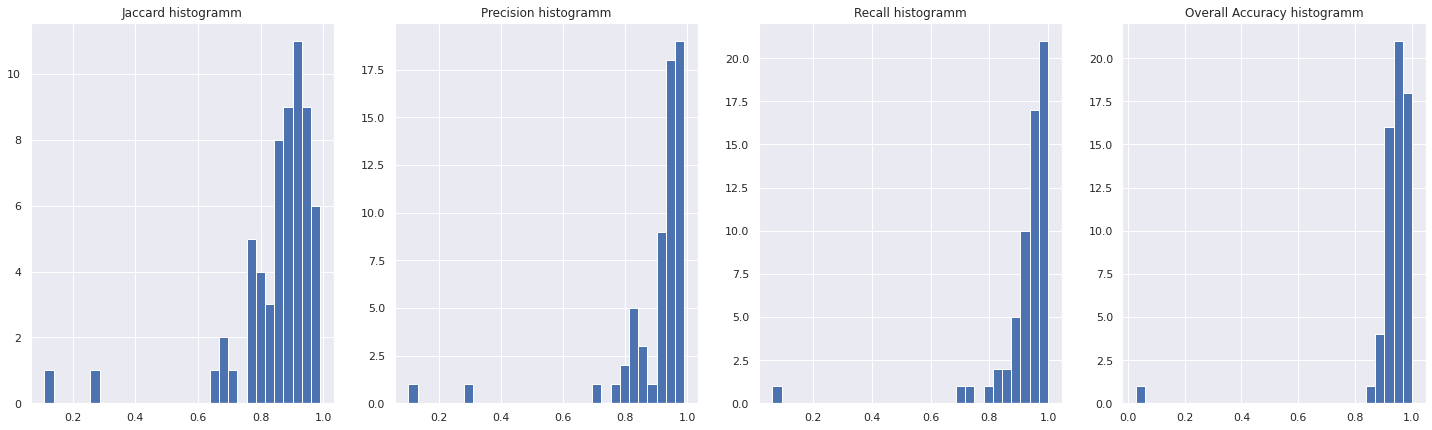

In [34]:
fig = plt.figure(figsize=(25, 7))
n_cols = 4
n_rows = 1

for i in range(1,5):
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.hist(df.iloc[:100,i].values,bins =30)
    ax.set_title(df.columns.values[i]+" histogramm")
    plt.grid(True)

#### Examples of classified images

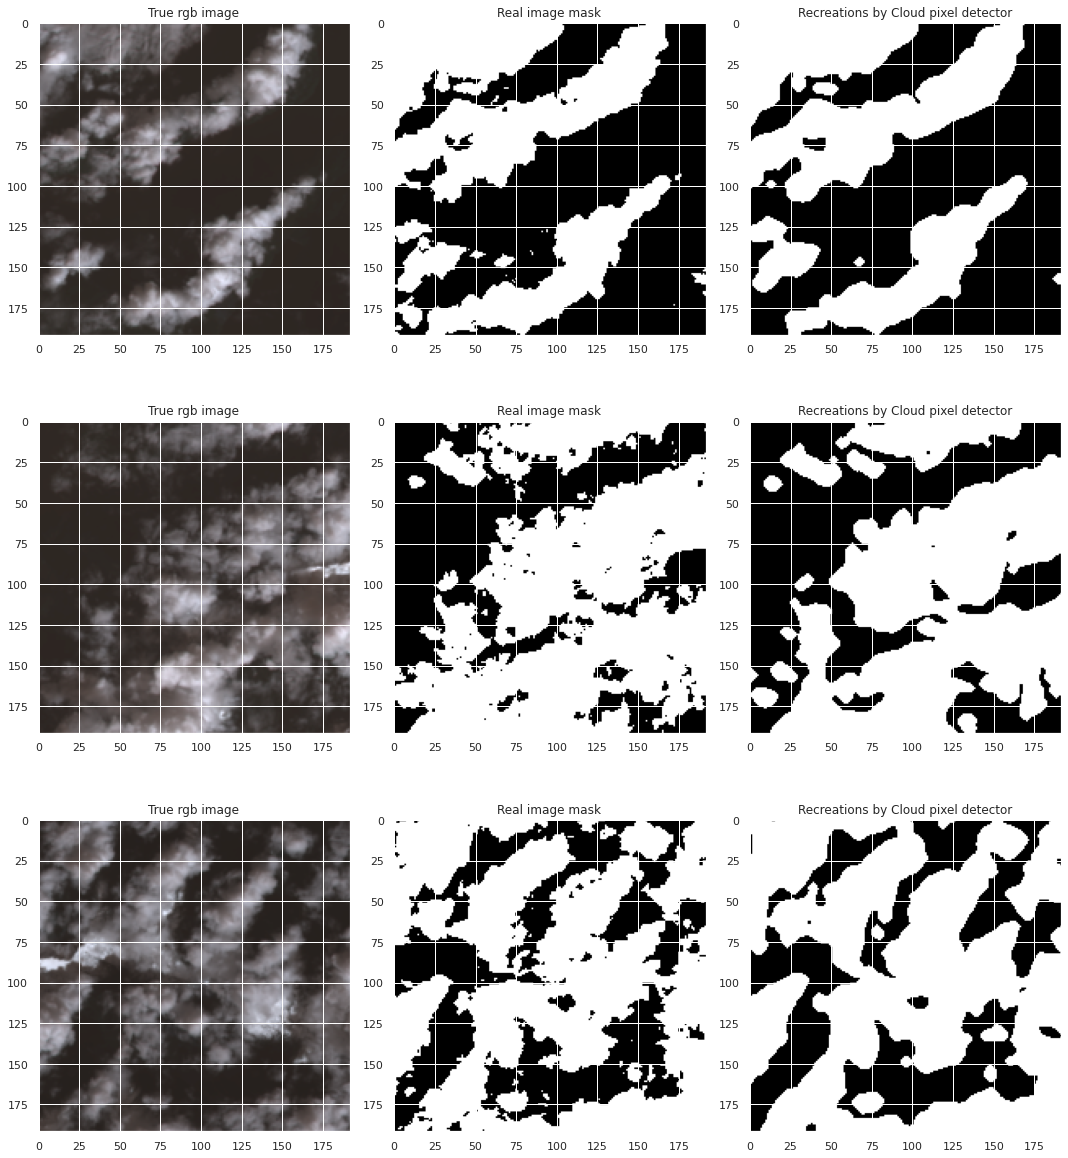

In [35]:
plot_image_recreations(34,37)

#### Examples of  classified images

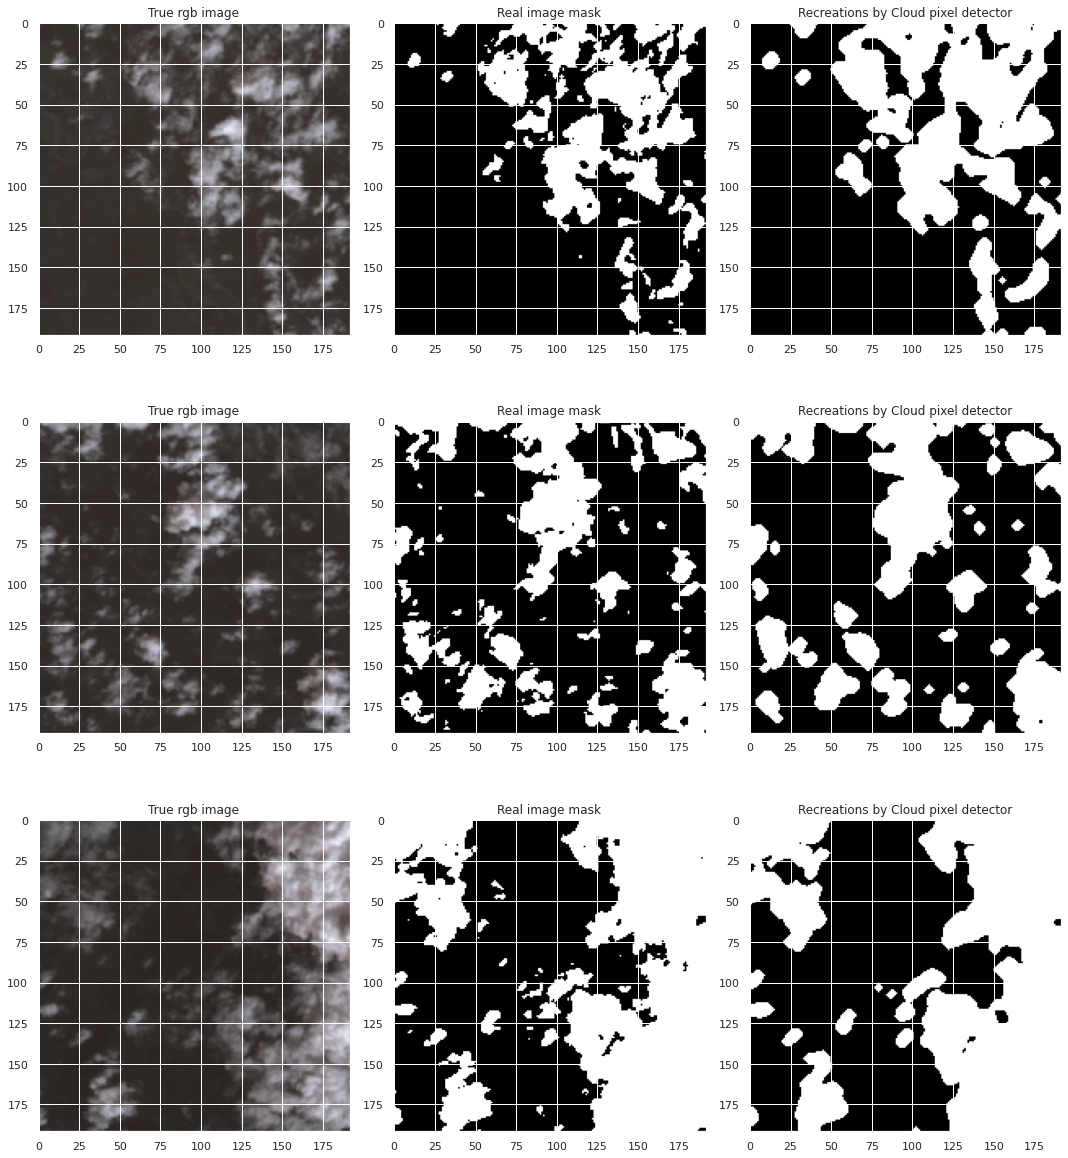

In [36]:
plot_image_recreations(5,8)

#### Let us compare results to Xgboost trained on corrected cloud masks

In [37]:
cloud_detector_RF = CloudDetector(threshold=0.7, average_over=4, dilation_size=2,model_filename = "xgboost_cor.dat")

/home/ilya/Machine learning/Project/FP/cloudless/models/xgboost_cor.dat


In [38]:
cloud_probs = cloud_detector_RF.get_cloud_probability_maps(imgs)

In [39]:
cloud_masks = cloud_detector_RF.get_cloud_masks(imgs)

In [42]:
jac_score = []
prec_score = []
recall = []
acc_score = []
for i in range(len(cloud_masks)):
    pred = cloud_masks[i].flatten()
    true = imgs_mask[i].flatten()
    jac_score.append(np.round(jaccard_score(true,pred),2))
    prec_score.append(np.round(precision_score(true,pred),2))
    recall.append(np.round(recall_score(true,pred),2))
    acc_score.append(np.round(accuracy_score(true,pred),2))
jac_score.append(np.round(np.mean(jac_score),2))
prec_score.append(np.round(np.mean(prec_score),2))
recall.append(np.round(np.mean(recall),2))
acc_score.append(np.round(np.mean(acc_score),2))

jac_score.append(np.round(np.std(jac_score),2))
prec_score.append(np.round(np.std(prec_score),2))
recall.append(np.round(np.std(recall),2))
acc_score.append(np.round(np.std(acc_score),2))
dic = {'image №':list(range(len(cloud_masks)))+['mean']+['std'],'Jaccard':jac_score,'Precision':prec_score,'Recall':recall,'Overall Accuracy':acc_score}
df=pd.DataFrame(dic)
df.set_index('image №')
df.iloc[59:]

,image №,Jaccard,Precision,Recall,Overall Accuracy
59,mean,0.87,0.93,0.93,0.95
60,std,0.10,0.08,0.06,0.03


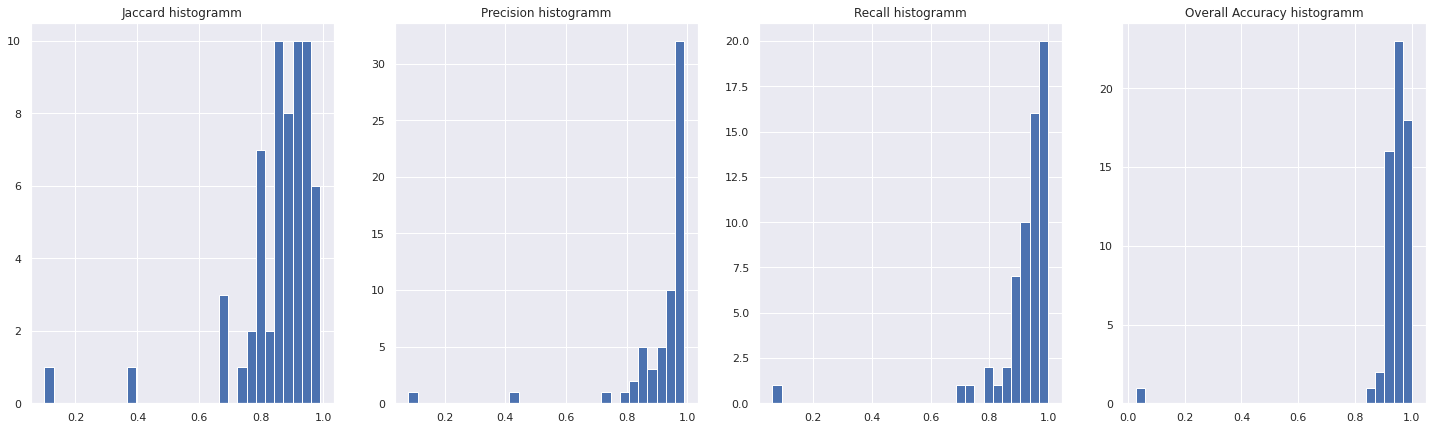

In [41]:
fig = plt.figure(figsize=(25, 7))
n_cols = 4
n_rows = 1

for i in range(1,5):
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.hist(df.iloc[:100,i].values,bins =30)
    ax.set_title(df.columns.values[i]+" histogramm")
    plt.grid(True)